In [1]:
import os
import cv2
import glob
import time
import shutil

import random
import numpy as np
import pandas as pd
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image, ImageTk
import tkinter as tk
from tkinter import Label, Button, PhotoImage, Frame

import warnings
warnings.filterwarnings('ignore')

In [2]:
!mkdir female_age_19_to_23\\sip
!mkdir female_age_19_to_23\\skip
!mkdir models

In [3]:
!mkdir google_scrape\\sip
!mkdir google_scrape\\skip
!mkdir google_scrape\\models

A subdirectory or file google_scrape\\sip already exists.
A subdirectory or file google_scrape\\skip already exists.
A subdirectory or file google_scrape\\models already exists.


In [4]:
files = glob.glob('google_scrape/*.jpg')

# Shuffle files
np.random.seed(0)
np.random.shuffle(files)

friends = glob.glob('friends/*')
# np.random.shuffle(friends)

In [5]:
# create the detector, using default weights
detector = MTCNN()

def resize_with_pad(img, padded_size):
    height, width = img.shape[:2]

    ratio = padded_size / max(height, width)
    padded_width = int(width * ratio)
    padded_height = int(height * ratio)

    img = cv2.resize(img, (padded_width, padded_height))

    delta_w = padded_size - padded_width
    delta_h = padded_size - padded_height
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    return new_img

def get_face(img):
    # detect faces in the image
    results = detector.detect_faces(img)
    if not results:
        raise Exception("Error: No face was found in this image.")
    
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
        
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2, y2 = x1 + width, y1 + height

    # extract the face
    face = img[y1:y2, x1:x2]
    face_patch = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r',facecolor='none')
    
    # Resize and pad the face to be a 256x256 square image
    square_face = resize_with_pad(face, 256)

    return square_face, face_patch

def plot_with_box(img, patch):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    ax.add_patch(patch)
    fig.show()
    return fig

def plot_multiple_with_box(imgs, patches):
    fig, ax = plt.subplots(1, len(imgs), figsize=(15, 10))
    for i in range(len(ax)):
        ax[i].imshow(imgs[i])
        ax[i].add_patch(patches[i])
    fig.show()
    return fig

In [13]:
class SwipingApp():

    def __init__(self, folder):
                
        # Create GUI
        self.gui = tk.Tk(className="Cafe")
        self.gui.minsize(width=100, height=100)
        self.headline = Label(text="Welcome to the Cafe!", font=(None, 25))
        self.headline.pack()

        # Get list of filepaths
        all_files = glob.glob(folder + '/downloaded/*.jpg')
        sip_files = glob.glob(folder + '/sip/*.jpg')
        skip_files = glob.glob(folder + '/skip/*.jpg')
                
        labeled_image_names = [os.path.basename(f) for f in sip_files + skip_files]
        self.image_paths = [f for f in all_files if os.path.basename(f) not in labeled_image_names]
        random.shuffle(self.image_paths)
        
        self.n_sip = len(sip_files)
        self.n_skip = len(skip_files)
        self.remaining = len(self.image_paths)
        
        print("{:,} images already labeled ({:,} sip, {:,} skip), {:,} images still unlabeled.".format(self.n_sip + self.n_skip, self.n_sip, self.n_skip, len(self.image_paths)))
        if not self.image_paths:
            return
        
        # Insert image
        self.sip_or_skip = []          # sip = 1, skip = 0
        
        self.path = self.image_paths[0]
        self.image_paths = self.image_paths[1:]
        self.img = Image.open(self.path).resize((512, 512))
        self.tk_img = ImageTk.PhotoImage(self.img)
        
        self.main_panel = Frame(self.gui)
        self.main_panel.pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        self.panel = Label(self.gui, image=self.tk_img, width=600, height=600)
        self.panel.pack(in_=self.main_panel, side=tk.LEFT)
        
#         self.tally = Frame(self.main_panel)
#         self.tally.pack(in_=self.main_panel, side=tk.RIGHT)
        
        self.sip_count = Label(text = "# Sips: {}\n# Skips: {}\n# Remaining: {}".format(self.n_sip, self.n_skip, self.remaining), font=("Helvetica", 20))
        self.sip_count.pack(in_=self.main_panel, side=tk.RIGHT)
#         self.skip_count = Label(text = "# Skips: {}".format(len(skip_files)), font=("Helvetica", 20))
#         self.sip_count.pack(in_=self.tally, side=tk.TOP)
#         self.skip_count.pack(in_=self.tally, side=tk.BOTTOM)
        
        # Add sip or skip labels
        self.btn_frame = Frame(self.gui)
        self.btn_frame.pack(side=tk.BOTTOM, fill=tk.BOTH, expand=True)
        
        self.btn_skip = Button(self.gui, text="Skip :(", command=self.skip, width=15, height=5, bg='red', fg='white', font=(None, 20))
        self.btn_sip = Button(self.gui, text="Sip :)", command=self.sip, width=15, height=5, bg='green', fg='white', font=(None, 20))
        self.btn_del = Button(self.gui, text="Delete image", command=self.delete, width=15, height=5, bg='black', fg='white', font=(None, 20))
        
        self.btn_skip.pack(in_=self.btn_frame, side=tk.LEFT)
        self.btn_sip.pack(in_=self.btn_frame, side=tk.LEFT)
        self.btn_del.pack(in_=self.btn_frame, side=tk.LEFT)

        # Start GUI
        self.gui.mainloop()
        
    def get_face_and_save(self):
        # Update image
        try:
            face = get_face(np.array(self.img_to_change))[0]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            cv2.imwrite(self.new_path, face)
        except:
            print("\tERROR: No face was found in", self.path)
            os.remove(self.path)
            os.remove(self.new_path)

        return
        
    def update_image(self, skip=False):
        if self.image_paths:
            self.remaining -= 1
            self.sip_count.configure(text = "# Sips: {}\n# Skips: {}\n# Remaining: {}".format(self.n_sip, self.n_skip, self.remaining))
            if not skip:
                self.get_face_and_save()                            # Crop face of previosuly selected image
                
            self.path = self.image_paths[0]                     # Get path of next image to display
            self.image_paths = self.image_paths[1:]             # Remove from list of remaining paths
            
            self.img = Image.open(self.path).resize((512, 512)) # Open and resize image
            self.tk_img = ImageTk.PhotoImage(self.img)          # Make a Tkinter photo object to display
            self.panel.configure(image=self.tk_img)             # Display image
            self.panel.image = self.tk_img
            
            
        else:
            if not skip:
                self.get_face_and_save()
            
            
            self.headline.destroy()
            self.panel.destroy()
            self.end = Label(text="There are no more images.\nThanks for sipping!", font=(None, 25), height=10)
            self.end.pack()
#             self.btn_frame.destroy()
            self.btn_skip["state"] = "disabled"
            self.btn_sip["state"] = "disabled"
            self.btn_delete["state"] = "disabled"
#             self.gui.destroy()
        
        return
        
    def skip(self):
        print("Skip", self.path)
        self.n_skip += 1
        self.sip_or_skip.append({self.path: 0})
        
        # Copy image to "skip" folder
        fname = os.path.basename(self.path)
        folder = self.path.split(fname)[0]
        self.new_path = folder[:-11] + "/skip/" + fname
        shutil.copy(self.path, self.new_path)
        
        # Copy image to get face later
        self.img_to_change = self.img.copy()
        
        # Change image in GUI
        self.update_image()
        
        # Will crop face after updating GUI
        
    def sip(self):
        print("Sip", self.path)
        self.n_sip += 1
        self.sip_or_skip.append({self.path: 1})
                
        # Copy image to "sip" folder
        fname = os.path.basename(self.path)
        folder = self.path.split(fname)[0]
        self.new_path = folder[:-11] + "/sip/" + fname
        shutil.copy(self.path, self.new_path)
        
        # Copy image to get face later
        self.img_to_change = self.img.copy()
        
        # Change image in GUI
        self.update_image()
        
        # Will crop face after updating GUI
        
    def delete(self):
        print("Delete", self.path)
                
        # Copy image to "sip" folder
        os.remove(self.path)
                
        # Change image in GUI
        self.update_image(skip=True)

In [15]:
app = SwipingApp('google_scrape')

1,166 images already labeled (520 sip, 646 skip), 12 images still unlabeled.
Sip google_scrape/downloaded\aaaaaaa.jpg
Sip google_scrape/downloaded\aaaaaaaa.jpg
Skip google_scrape/downloaded\aaaaaaaaa.jpg
Skip google_scrape/downloaded\aa.jpg
Sip google_scrape/downloaded\aaaa.jpg
Sip google_scrape/downloaded\aaaaaaaaaa.jpg
Skip google_scrape/downloaded\aaaaa.jpg
Skip google_scrape/downloaded\aaaaaa.jpg
Skip google_scrape/downloaded\aaaaaaaaaaa.jpg
Sip google_scrape/downloaded\aaaaaaaaaaaa.jpg
Sip google_scrape/downloaded\a.jpg
Skip google_scrape/downloaded\aaa.jpg


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\users\desid\anaconda3\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "<ipython-input-13-9d0bc98141b7>", line 126, in skip
    self.update_image()
  File "<ipython-input-13-9d0bc98141b7>", line 106, in update_image
    self.btn_delete["state"] = "disabled"
AttributeError: 'SwipingApp' object has no attribute 'btn_delete'


In [50]:
sip = 273
skip = 527
labeled = sip + skip
unlabeled = 189
both = 1991
del_rate = 1 - labeled / (both - unlabeled)
print("{:.1%} of images are getting thrown out.".format(del_rate))
print("At this rate, there will be a total of\n\t- {:.0f} images labeled\n\t- {:.0f} sip\n\t- {:.0f} skip".format(both*(1-del_rate), sip/labeled*both*(1-del_rate), skip/labeled*both*(1-del_rate)))

55.6% of images are getting thrown out.
At this rate, there will be a total of
	- 884 images labeled
	- 302 sip
	- 582 skip


In [90]:
path = "google_scrape/young_woman_beautiful_000120.jpg"
img_to_change = Image.open(path).resize((512, 512))
try:
    face = get_face(np.array(img_to_change))
    plt.imshow(face[0])
except:
    print("Uh oh")

Uh oh


In [ ]:
sip_files = glob.glob("sip")
skip_files = glob.glob("skip")

In [55]:
folder = "google_scrape"
all_files = glob.glob(folder + '/*.jpg')
sip_files = glob.glob(folder + '/sip/*.jpg')
skip_files = glob.glob(folder + '/skip/*.jpg')
labeled_image_names = [os.path.basename(f) for f in sip_files + skip_files]
image_paths = [f for f in all_files if os.path.basename(f) not in labeled_image_names]

print(len(all_files))
print(len(labeled_image_names))
print(len(image_paths))

881
881
0


In [136]:
gender_dict = {"male": "0", "female": "1", "any": "\d"}
race_dict = {"white": "0", "black": "1", "asian": "2", "indian": "3", "other": "4", "any": "\d"}

def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_path(age=25, gender="any", race="any", print_matches=False):
    """
    age: int, default = 25
        * acceptable values are 0 to 116
        * can also input "any" for no preference
        * indicates the age of the person
    gender: int, default = "male""
        * acceptable values are {"male", "female"}
        * can also input "any" for no preference
    race: int, default = "any"
        * acceptable values {"white", "black", "asian", "indian", "other"}
        * "other" includes (like Hispanic, Latino, Middle Eastern)
        * can also input "any" for no preference

    print_matches: bool, default = False
        * Whether or not to print the total number of matches that fit the input criteria
    """
    if age == "any": age = '\d{1,3}'
    else: age = str(age)

    gender = gender_dict[gender]
    race = race_dict[race]

    params = [age, gender, race]
    pattern = '_'.join(params) + "_\d{17}.jpg"

    matches = re.findall(pattern, files)
    if print_matches: print("{:,} total images fit this description.".format(len(matches)))
    
    path = "UTKWild/" + random.choice(matches)
    return path

def save_filenames(folder):
    files = os.listdir(folder)
    files = '\n'.join(files)
    with open(f'{folder}.txt', 'w') as f:
        f.write(files)

def get_filenames(folder):
    with open(f'{folder}.txt', 'r') as f:
        files = f.read()
    return files

def resize_with_pad(img, padded_size):
    height, width = img.shape[:2]

    ratio = padded_size / max(height, width)
    padded_width = int(width * ratio)
    padded_height = int(height * ratio)

    img = cv2.resize(img, (padded_width, padded_height))

    delta_w = padded_size - padded_width
    delta_h = padded_size - padded_height
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    return new_img

def get_face(img):
    # create the detector, using default weights
    detector = MTCNN()

    # detect faces in the image
    results = detector.detect_faces(img)

    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2, y2 = x1 + width, y1 + height

    # extract the face
    face = img[y1:y2, x1:x2]
    face_patch = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r',facecolor='none')
    
    # Resize and pad the face to be a 256x256 square image
    square_face = resize_with_pad(face, 256)

    return square_face, face_patch

def plot_with_box(img, patch):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    ax.add_patch(patch)
    fig.show()
    return fig

def plot_multiple_with_box(imgs, patches):
    '''
    This function displays all images and their corresponding patches in a 
    grid-like pattern on the same figure.

    Inputs:
    -------------------------
    imgs: list of cv2 images / 2D arrays / 3D arrays
    patches: list of matplotlib.patches.Rectangle objects

    Returns:
    -------------------------
    fig: matplotlib.pyplot.figure
    '''
    # Calculate the number of rows needed for the plot
    n_cols = 5
    n_rows = len(imgs) // n_cols

    # Plot the images and face patches
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(25, 7*n_rows))
    for i, axes in enumerate(ax.flatten()):
        axes.imshow(imgs[i])            # Display image
        axes.add_patch(patches[i])      # Add face patch
        axes.set_yticks([])             # Remove yticks
        axes.set_xticks([])             # Remove xticks
    
    # Show fig
    fig.show()
    return fig

<ipython-input-108-9b96b0e9ab95>:106: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


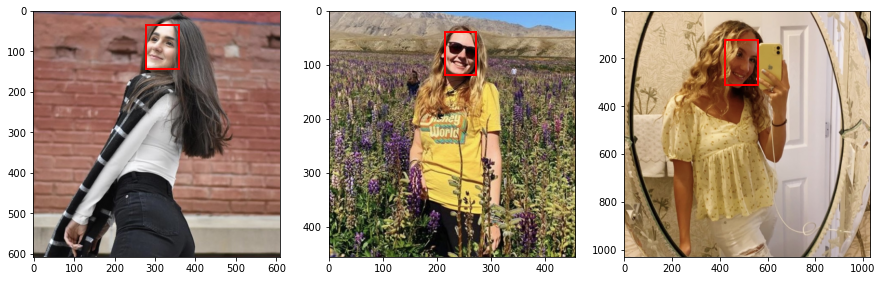

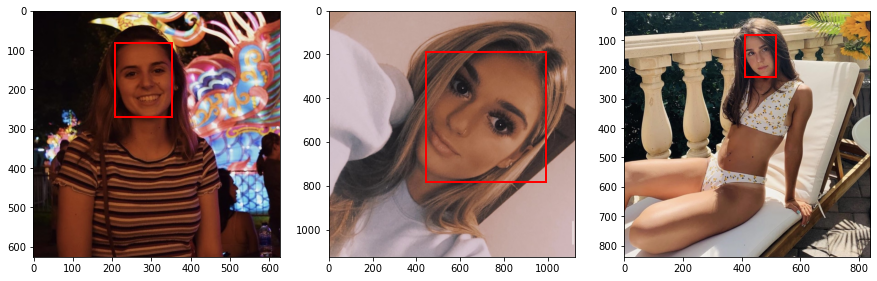

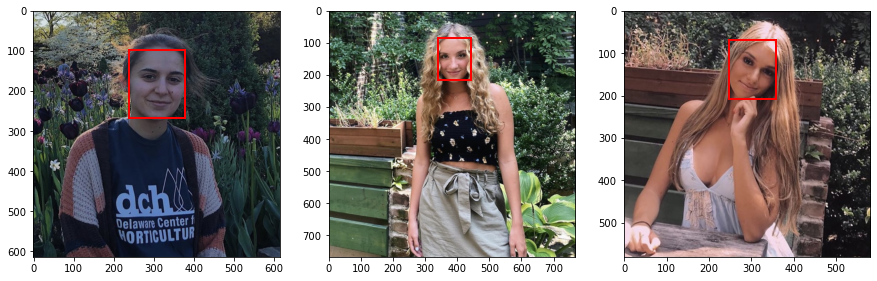

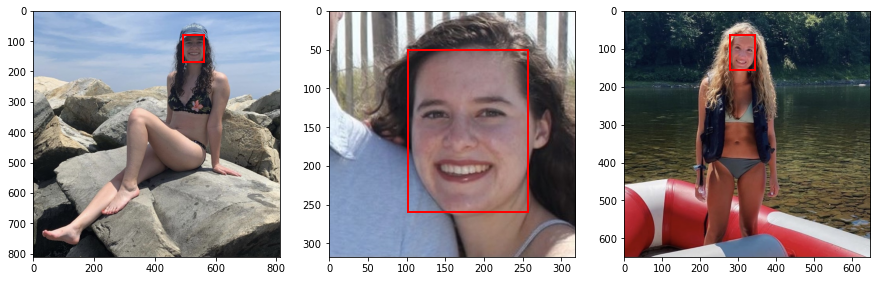

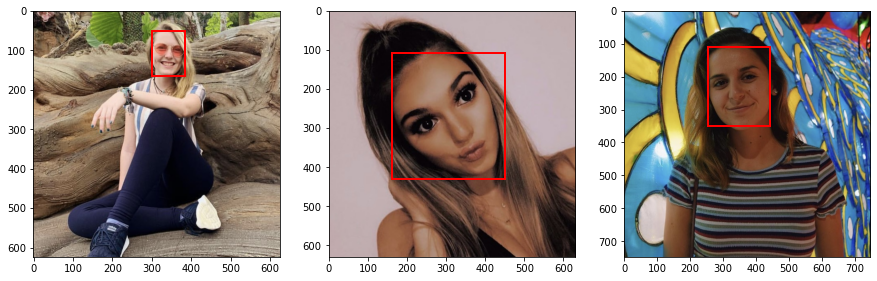

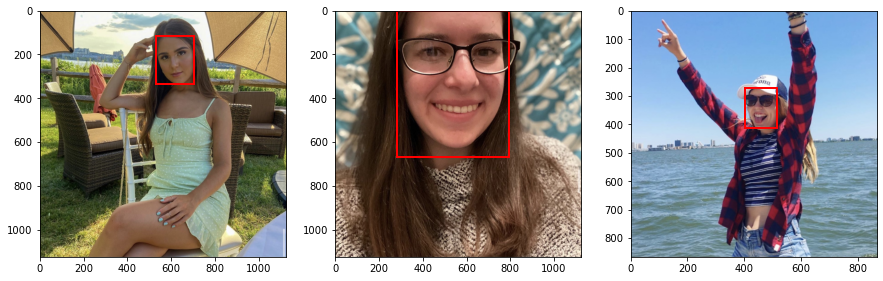

In [111]:
for friend in range(len(friends) // 3):
    imgs = []
    face_patches = []
    for i in range(3):
        f = friends[i + friend*3]
        imgs.append(load_image(f))
        face, patch = get_face(imgs[i])
        face_patches.append(patch)

    plot_multiple_with_box(imgs, face_patches)

In [138]:
friend_imgs = [load_image(f) for f in friends]
face_patches = [get_face(img)[1] for img in friend_imgs]

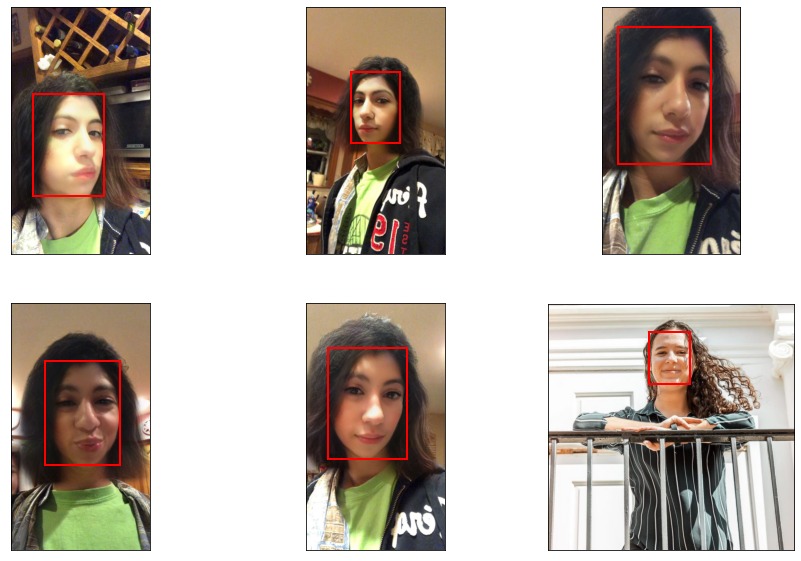

In [135]:
plot_multiple_with_box(friend_imgs, face_patches);

RuntimeError: Can not put single artist in more than one figure

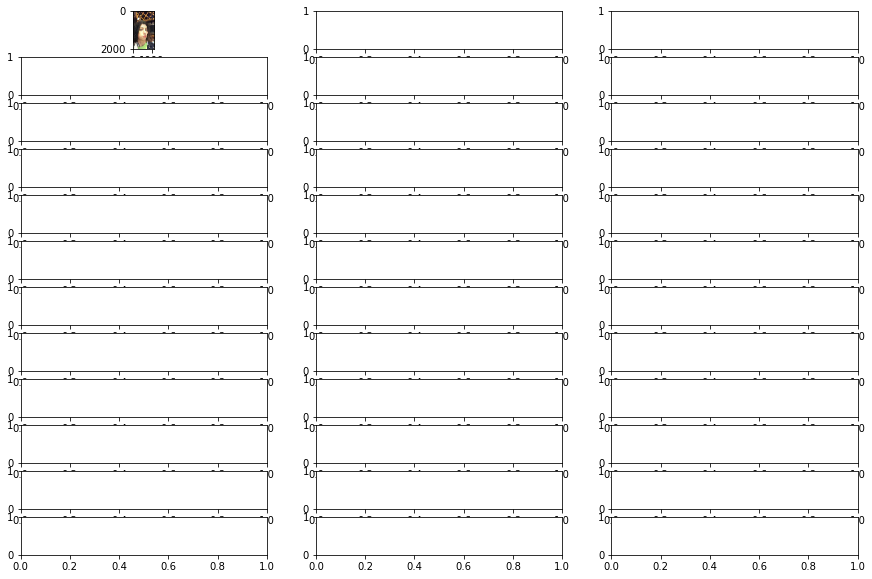

In [118]:
# plot_multiple_with_box(friend_imgs, face_patches);

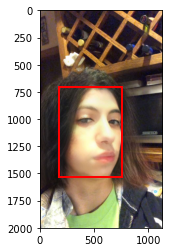

In [133]:
imgs = []
face_patches = []
i = 0

imgs.append(load_image(friends[i]))
face, patch = get_face(imgs[i])
face_patches.append(patch)

fig, ax = plt.subplots()
ax.imshow(imgs[i])
ax.add_patch(patch)